In [2]:
from matplotlib import pyplot as plt

import numpy as np

import torch

import pyro
import pyro.distributions as dist

from util import initialize_model

Create a toy model.

In [3]:
def model(data):
    loc = pyro.sample("loc", dist.Normal(0,1))
    return pyro.sample("out", dist.Normal(loc, 1), obs=data)

data = torch.tensor([1])

Compute potential functions from the using different scale likelihoods and plot them.

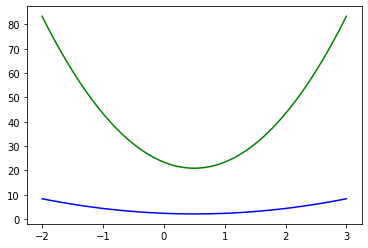

In [9]:
init1 = initialize_model(
    model,
    model_args=(data,),
    scale_likelihood=1
)
potential_fn1 = init1[1]

init2 = initialize_model(
    model,
    model_args=(data,),
    scale_likelihood=10
)
potential_fn2 = init2[1]

num_samples=50
x = np.linspace(-2, 3, num=num_samples)
y1 = np.empty(num_samples)
y2 = np.empty(num_samples)
with torch.no_grad():
    for i in range(num_samples):
        y1[i] = potential_fn1({"loc": torch.from_numpy(x[[i]])})
        y2[i] = potential_fn2({"loc": torch.from_numpy(x[[i]])})
fig, ax = plt.subplots(1, 1)
ax.plot(x, y1, "b")
ax.plot(x, y2, "g")
plt.show()